In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load Libraries

In [2]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim import corpora
import gensim
from gensim.utils import simple_preprocess
from gensim import models

import pandas as pd

import re

from nltk.corpus import stopwords
from src.data.make_dataset import lematize

from sklearn.decomposition import TruncatedSVD

import pyLDAvis
import pyLDAvis.gensim 

from src.data.DBConnection import DBConnection
db = DBConnection()

In [10]:
logging.getLogger().setLevel(logging.ERROR)

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Build Features

In [4]:
sql = "SELECT details FROM positions;"
query = db.cur.execute(sql)
documents = query.fetchall()

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def process_documents(documents):
    # try new preprocessing steps:
    data = list(documents)
    # remove \n
    data = [text[0].replace("\n", " ") for text in data]
    # remove https:// links 
    data = [re.sub(r"((https{0,1}\:/\/\w{3}\S+)|(w{3}\S+))", "", text) for text in data]
    # remove emails:
    data = [re.sub(r"(\S+@\S+)", "", text) for text in data]
    # remove phone numbers:
    data = [re.sub(r"([\+\s01-]*\(*\d{3}\)*[-\s]\d{3}[-\s]\d{4})", "", text) for text in data]
    # remove uf0b7
    data = [re.sub(r"(\uf0b7)", "", text) for text in data]
    # remove handles:
    data = [re.sub(r"(\@\S+)", "", text) for text in data]
    # remove french documents
    data = [doc for doc in data if "une" not in doc and "connaissance" not in doc]
    return data

def docs_to_words(documents):
    for doc in documents:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [192]:
# get stop words and add some super-common words amoung the documents
stop_words = stopwords.words('english')
# stop_words.extend(["work", "experience", "team", "technology", "skill", "information", "project", "projects", "skills"])
stop_words.extend(["data", "yelp", "agoda"])


# clean all the documents (i.e., use regex to remove emails, urls, phone numbers, french documents, etc.)
clean_docs = process_documents(documents)

# use simple_preprocess to remove punctuation:
data_words = list(docs_to_words(clean_docs))

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in data_words:
    for token in text:
        frequency[token] += 1
        
frequency_threshold = 15
processed_corpus = [[token for token in text if frequency[token] > frequency_threshold] for text in data_words]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [193]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(processed_corpus, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[processed_corpus], threshold=25)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(processed_corpus)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form trigrams:
data_words_trigrams = make_trigrams(data_words_bigrams)

# Lematize docs:
data_lemmatized = [lematize(words).split(" ") for words in data_words_trigrams]

# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Bag of words:
corpus = [id2word.doc2bow(text) for text in texts]

# TF-IDF matrix:
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 28.9 s


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 1min 2s


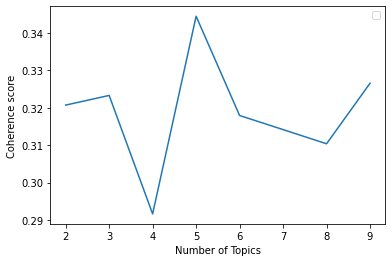

In [194]:
%%time
# determine optimal number of topics using coherence score:
coherence_vals = []
model_list =[]
start = 2
stop = 10
step = 1

for num_topics in range(start, stop, step):
    # make LDa model and calc coherence:
    model = LdaModel(corpus=tfidf_corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v', processes=1)
    coherence_vals.append(coherence_model.get_coherence())
    
x = range(start, stop, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend()

In [195]:
best_model = model_list[coherence_vals.index(max(coherence_vals))]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [196]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, tfidf_corpus, id2word)
vis

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.006339  0.006375       1        1  27.916397
3     -0.001312 -0.013849       2        1  27.110907
0     -0.006900 -0.003316       3        1  18.082260
4      0.016182  0.000952       4        1  14.245028
2     -0.001631  0.009839       5        1  12.645409, topic_info=             Term       Freq      Total Category  logprob  loglift
1125     security   8.000000   8.000000  Default  30.0000  30.0000
2484     chipotle   4.000000   4.000000  Default  29.0000  29.0000
3752           td   2.000000   2.000000  Default  28.0000  28.0000
2294   accounting  14.000000  14.000000  Default  27.0000  27.0000
4539      mozilla   2.000000   2.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
55    engineering   1.438475  13.636282   Topic5  -6.9572  -0.1813
168          tool   1.363355  10.903436   Topic5  -7.0108  -0.0113
415        system   1.384359  12.022169   Topic5  -6.9955  -0.0936
645      solution   1.387795  13.213390   Topic5  -6.9930  -0.1856
141        report   1.367563  11.927139   Topic5  -7.0077  -0.0979

[385 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.292735    ability
0         2  0.292735    ability
0         3  0.195157    ability
0         4  0.195157    ability
0         5  0.097578    ability
...     ...       ...        ...
1142      1  0.475974   wireless
4743      2  0.581055       wsib
5166      1  0.607730        wsp
2453      2  0.600341     wysdom
2454      2  0.655362  wysdom_ai

[653 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [197]:
# display topics:
# topics = model_list[3].print_topics(num_words=5)

topics = best_model.print_topics(num_words=5)
topics_df = pd.DataFrame(topics)
topics_df = topics_df[1].str.replace("\\s\\+", "", regex=True).str.replace('\\"', "").str.split(" ", expand=True).T
topics_df.columns = [f"topic_{t+1}" for t in topics_df.columns]
    
topics_df

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.002*machine_learning,0.002*product,0.002*model,0.002*accounting,0.002*client
1,0.002*model,0.001*analytics,0.001*security,0.002*client,0.001*product
2,0.001*financial,0.001*customer,0.001*client,0.002*financial,0.001*project
3,0.001*business,0.001*machine_learning,0.001*business,0.002*project,0.001*accounting
4,0.001*ai,0.001*solution,0.001*product,0.001*design,0.001*design


# Observations

Improved model coherence score and subjective results by using TF-IDF and decreasing the bi- and tri-gram model parameters. LDA model seems to be able to tease out the major topics, which we expected to be:<br>
1. Data Scientist
2. Data Analyst
3. Accountant
4. Consultant
5. Engineer (Civil) - only small amount of these in dataset
<br>
I'm fairly pleased with the results so far. I think the model would have performed better if some of the topics were more distinct (i.e., Data Analysts and Data Scientists are often very similar).  The dataset is also heavily imbalanced since I collected way more Data Analyst + Scientist and only changed the searches at the end. Also I think a lot of the job descriptions were further tailored to my resume, so it was hard to get many different kinds of job descriptions.
<br><br>
Further Research<br>
Look into whether the job title matches the topics produced using the LDA model.